In [61]:
import numpy as np
import pandas as pd
pd.set_option('max_rows',38)
pd.set_option('max_columns',25)
import time
import pickle
from tqdm import tqdm
import myslack_incomming

# model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils
from keras.layers import Activation, BatchNormalization
import xgboost
from scipy.sparse import csr_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn import preprocessing


# Ver 1

# Data Check

#### - train.csv

In [52]:
train = pickle.load(open("./data/final_train_Ver1.pkl", "rb"))
print("test data shape: "+str(train.shape))

test data shape: (95674, 5482)


#### - test.csv

In [112]:
test = pickle.load(open("./data/final_test_Ver1.pkl", "rb"))
print("test data shape: "+str(test.shape))

test data shape: (95674, 5481)


#### - sample_submission.csv

In [54]:
samplesub = pd.read_csv("./data/sample_submission.csv")
print("sample_submission data shape: "+str(samplesub.shape))

sample_submission data shape: (95674, 39)


---

# Modeling 8 - Neural Network

### Train_X, Train_y

In [86]:
X = train.drop(columns='TripType')
y = train['TripType']

In [87]:
len(y.unique()), y.unique()

(38, array([37, 22, 18,  5, 27, 33, 13,  3, 34,  4,  6, 31, 17, 30,  9, 28, 12,
        29, 24, 32,  2,  0,  1, 16, 25, 35, 23, 19, 26, 10, 21, 36, 11, 15,
        14, 20,  8,  7]))

In [88]:
y.unique()

array([37, 22, 18,  5, 27, 33, 13,  3, 34,  4,  6, 31, 17, 30,  9, 28, 12,
       29, 24, 32,  2,  0,  1, 16, 25, 35, 23, 19, 26, 10, 21, 36, 11, 15,
       14, 20,  8,  7])

In [89]:
preprocessing.LabelEncoder().fit_transform(y.unique())

array([37, 22, 18,  5, 27, 33, 13,  3, 34,  4,  6, 31, 17, 30,  9, 28, 12,
       29, 24, 32,  2,  0,  1, 16, 25, 35, 23, 19, 26, 10, 21, 36, 11, 15,
       14, 20,  8,  7])

In [90]:
train['TripType'].replace(y.unique(),preprocessing.LabelEncoder().fit_transform(y.unique()),inplace=True)

In [91]:
len(y.unique()), y.unique()

(38, array([37, 22, 18,  5, 27, 33, 13,  3, 34,  4,  6, 31, 17, 30,  9, 28, 12,
        29, 24, 32,  2,  0,  1, 16, 25, 35, 23, 19, 26, 10, 21, 36, 11, 15,
        14, 20,  8,  7]))

In [92]:
X = csr_matrix(X); X

In [130]:
csr_test = csr_matrix(test); csr_test

<95674x5481 sparse matrix of type '<class 'numpy.int64'>'
	with 1130483 stored elements in Compressed Sparse Row format>

## Keras

### Train Test Split

In [218]:
X_train, X_test, y_train0, y_test0 = train_test_split(X, y, test_size=0.3)

X_train.shape[0], X_test.shape[0], len(y_train0), len(y_test0)

(66971, 28703, 66971, 28703)

In [219]:
Y_train = np_utils.to_categorical(y_train0, 38)
Y_test = np_utils.to_categorical(y_test0, 38)

In [220]:
dense = 10
lr = 1

In [221]:
NN_model_Adadelta = Sequential()
NN_model_Adadelta.add(Dense(dense, input_dim=5481, kernel_initializer="glorot_uniform"))
NN_model_Adadelta.add(BatchNormalization())
NN_model_Adadelta.add(Activation('relu'))
NN_model_Adadelta.add(Dense(38, activation="softmax", kernel_initializer="glorot_uniform"))
NN_model_Adadelta.compile(optimizer=Adadelta(lr=lr), loss='binary_crossentropy', metrics=["accuracy"])

In [222]:
NN_model_Adadelta.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 10)                54820     
_________________________________________________________________
batch_normalization_20 (Batc (None, 10)                40        
_________________________________________________________________
activation_20 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 38)                418       
Total params: 55,278
Trainable params: 55,258
Non-trainable params: 20
_________________________________________________________________


In [223]:
epochs = 3
batch_size = 5000

In [224]:
%%time
hist = NN_model_Adadelta.fit(X_train, Y_train, 
                              epochs=epochs, batch_size=batch_size, 
                              validation_data=(X_test, Y_test), 
                              verbose=1)

myslack_incomming.send_slack('NN_model_Adadelta finish! dense: {}, lr: {},  val_acc: {} '
                             .format(dense,lr,hist.history['val_acc'][-1]))

Train on 66971 samples, validate on 28703 samples
Epoch 1/3
66971/66971 [==============================] - 29s 440us/step - loss: 0.1213 - acc: 0.9737 - val_loss: 0.1194 - val_acc: 0.9737
Epoch 2/3
66971/66971 [==============================] - 27s 410us/step - loss: 0.1180 - acc: 0.9737 - val_loss: 0.1171 - val_acc: 0.9737
Epoch 3/3
66971/66971 [==============================] - 28s 422us/step - loss: 0.1161 - acc: 0.9737 - val_loss: 0.1151 - val_acc: 0.9737
<Response [200]>
CPU times: user 1min 26s, sys: 14.3 s, total: 1min 41s
Wall time: 1min 29s


### Confusion Matrix

In [225]:
Y_test.argmax(axis=1)

array([ 0,  6,  0, ..., 23, 23, 34])

In [226]:
y_pred = NN_model_Adadelta.predict_classes(X_test)
confusion_matrix(Y_test.argmax(axis=1), y_pred)

array([[   1,    0,    0, ...,    0,    0,   45],
       [   0,    0,    5, ...,    0,    1,    3],
       [   1,    0,   51, ...,    0,    8,  107],
       ...,
       [   0,    0,   29, ...,    0,   15,   18],
       [   0,    0,   33, ...,    0,   11,    8],
       [   0,    0,    5, ...,    0,    5, 1942]])

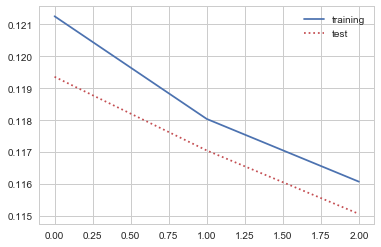

In [227]:
plt.plot(hist.history['loss'], 'b-', label="training")
plt.plot(hist.history['val_loss'], 'r:', label="test")
plt.legend()
plt.show()

In [228]:
'val_acc: '+str(hist.history['val_acc'][-1])

'val_acc: 0.9736930337599444'

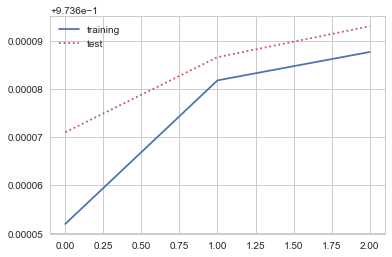

In [232]:
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

### prediction

In [233]:
result = NN_model_Adadelta.predict_proba(csr_test)
result

array([[0.02385901, 0.01995604, 0.02762974, ..., 0.02162622, 0.02951301,
        0.03829303],
       [0.02281144, 0.01979733, 0.02619853, ..., 0.01960183, 0.0301157 ,
        0.04335504],
       [0.01835045, 0.01407099, 0.02948502, ..., 0.01629926, 0.02560336,
        0.04665631],
       ...,
       [0.01782967, 0.01621671, 0.02506788, ..., 0.01664026, 0.03176044,
        0.05135722],
       [0.02356441, 0.02055264, 0.02102651, ..., 0.0201694 , 0.04079145,
        0.04267124],
       [0.02871441, 0.01535765, 0.0200161 , ..., 0.01344992, 0.04362255,
        0.05095064]], dtype=float32)

### Make Submission CSV file

In [234]:
subform_df_columns = samplesub.columns[1:]
result_df = pd.DataFrame(result)
result_df.columns = subform_df_columns
subform_df = pd.concat([test.reset_index()['VisitNumber'],result_df],axis=1)
subform_df.set_index('VisitNumber',inplace=True)
subform_df.tail()

,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,TripType_15,TripType_18,TripType_19,...,TripType_34,TripType_35,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
VisitNumber,,,,,,,,,,,,,,,,,,,,,,,,,
191338,0.024051,0.015761,0.025916,0.033041,0.013430,0.043308,0.044685,0.011683,0.017574,0.026388,0.027096,0.042023,...,0.034410,0.043411,0.017983,0.024351,0.029578,0.013288,0.014173,0.054790,0.033647,0.014118,0.036205,0.050518
191339,0.020113,0.016625,0.022988,0.026772,0.018871,0.041973,0.044533,0.014464,0.018181,0.026120,0.030928,0.037780,...,0.032798,0.035936,0.022964,0.023150,0.033612,0.015405,0.014813,0.049952,0.032276,0.015987,0.037370,0.053427
191340,0.017830,0.016217,0.025068,0.023101,0.020943,0.044278,0.042084,0.017685,0.017031,0.026441,0.033037,0.029850,...,0.033279,0.033574,0.028306,0.025166,0.034735,0.018370,0.014969,0.045003,0.028081,0.016640,0.031760,0.051357
191341,0.023564,0.020553,0.021027,0.028608,0.024035,0.031954,0.035023,0.016089,0.025114,0.023663,0.027448,0.039884,...,0.028028,0.030175,0.019105,0.021535,0.032013,0.018578,0.020709,0.044014,0.034498,0.020169,0.040791,0.042671
191348,0.028714,0.015358,0.020016,0.046546,0.012074,0.038042,0.047435,0.010720,0.017630,0.022328,0.020763,0.057430,...,0.033161,0.042593,0.014402,0.019884,0.023862,0.010258,0.016792,0.046496,0.042503,0.013450,0.043623,0.050951


In [235]:
subform_df.to_csv('./NN/Adadelta_bi_cro_den{}_lr{}_epo{}_batch_size{}.csv'
                  .format(dense,lr,epochs,batch_size))

## 모델저장

In [177]:
NN_model_Adadelta.save('./NN/Adadelta_bi_cro_den{}_lr{}_epo{}_basi{}.hdf5'.format(dense,lr,epochs,batch_size))

In [178]:
from keras.models import load_model

model = load_model('./NN/Adadelta_bi_cro_den{}_lr{}_epo{}_basi{}.hdf5'.format(dense,lr,epochs,batch_size))

In [179]:
model.predict_classes(X_test)

array([24, 32,  5, ..., 31,  0, 37])